In [1]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup as bs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Bidirectional, LSTM, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
import pickle

pd.set_option('display.width', 140)
pd.set_option('display.max_colwidth', 80)

## Data wrangling - AI model

In [2]:
df_news_type = pd.read_csv('data/news_ai.csv')
df_news_type.sample(5)

,type,headline
82134,analyst_action,barclays upgrades jd on continued strength in china's e-commerce sector
376674,company_guidance,kinross cuts gold guidance figures
602276,redundant_meaningless,update: catalyst pharma notes topline results for investigator-sponsored pha...
297297,redundant_meaningless,"grubhub says company is processing 200,000 orders per day"
407166,corporate_action,"materion cutting outlook, cites delayed shipments; announces $50m buyback plan"


In [3]:
df_news_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654642 entries, 0 to 654641
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   type      418013 non-null  object
 1   headline  654642 non-null  object
dtypes: object(2)
memory usage: 10.0+ MB


In [4]:
df_news_type.shape

(654642, 2)

In [5]:
df_news_type.isnull().sum()

type        236629
headline         0
dtype: int64

In [6]:
df_news_type.dropna(subset=['type'], inplace=True)

In [7]:
df_news_type.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418013 entries, 0 to 654636
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   type      418013 non-null  object
 1   headline  418013 non-null  object
dtypes: object(2)
memory usage: 9.6+ MB


In [8]:
# create mapper
mapper = {}
for i, news in enumerate(df_news_type['type'].unique()):
    mapper[news] = i

print(mapper)

{'redundant_meaningless': 0, 'corporate_action': 1, 'earnings': 2, 'options': 3, 'merger_acquisition': 4, 'company_guidance': 5, 'analyst_action': 6}


In [9]:
# create sentiment dict for later use
sentiment_dict = {}
for k, v in mapper.items():
    sentiment_dict[v] = k

print(sentiment_dict)

{0: 'redundant_meaningless', 1: 'corporate_action', 2: 'earnings', 3: 'options', 4: 'merger_acquisition', 5: 'company_guidance', 6: 'analyst_action'}


In [10]:
df_news_type['type'] = df_news_type['type'].map(mapper)
df_news_type.head()

,type,headline
0,0,- german council of economic advisors says coronavirus pandemic means recess...
1,0,- russia's federal anti-monopoly service says bayer's takeover of monsanto c...
2,0,- s&p placed icahn enterprises on credit watch 'negative' from 'stable'; rat...
3,0,"-bluemountain capital management says pg&e's ""reckless"" chapter 11 filing ""w..."
6,1,: sports direct international reports 5.5% stake in performance sports group...


In [11]:
count = pd.concat([df_news_type['type'].value_counts(), df_news_type['type'].value_counts() / len(df_news_type['type']) * 100], axis=1)
count.insert(0, 'newcol', count.index.map(sentiment_dict))
count.columns = ['type', 'count', '%']
count.sort_values(by='%', ascending=False)

,type,count,%
6,analyst_action,126043,30.152890
2,earnings,108442,25.942255
1,corporate_action,87842,21.014179
0,redundant_meaningless,58955,14.103628
5,company_guidance,20402,4.880709
4,merger_acquisition,11674,2.792736
3,options,4655,1.113602


## Data preprocessing

In [12]:
# train test split
train, test = train_test_split(df_news_type, test_size=0.2)

In [13]:
X_train = np.array(train['headline'].tolist().copy())
y_train = keras.utils.to_categorical(train['type'].astype('int64'))

X_test = np.array(test['headline'].tolist().copy())
y_test = keras.utils.to_categorical(test['type'].astype('int64'))

In [14]:
# declare variables for preprocessing
vocab_size = 1000
embedding_dim = 16
max_length = 142
trunc_type = 'post'
padding_type = 'post'
oov_token = '<OOV>'

# create tokenizer object
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)
# tokenizer.word_index

In [15]:
# create sequence
X_tr_seq = tokenizer.texts_to_sequences(X_train)
X_tr_pad = pad_sequences(X_tr_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [16]:
# preprocess labels
X_te_seq = tokenizer.texts_to_sequences(X_test)
X_te_pad = pad_sequences(X_te_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [17]:
# save tokenizer on system
with open('models/ai_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Modeling

In [18]:
# build neural network
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GlobalAveragePooling1D())
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 142, 16)           16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                544       
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 231       
Total params: 16,775
Trainable params: 16,775
Non-trainable params: 0
_________________________________________________________________


In [19]:
# add early stopping with patience
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [20]:
# fit model
num_epochs = 20
history = model.fit(X_tr_pad, y_train, epochs=num_epochs, validation_data=(X_te_pad, y_test), verbose=0, callbacks=[es])

Epoch 00012: early stopping


In [21]:
# evaluate model
_, train_acc = model.evaluate(X_tr_pad, y_train, verbose=0)
_, test_acc = model.evaluate(X_te_pad, y_test, verbose=0)
print(f'Training accuracy: {train_acc:.3f}, Test accuracy: {test_acc:.3f}')

Training accuracy: 0.984, Test accuracy: 0.982


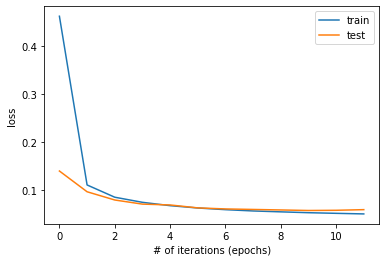

In [22]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.ylabel('loss')
plt.xlabel('# of iterations (epochs)')
plt.show()

In [23]:
# testing 9 simple headlines
phrase1 = 'Pfizer receives FDA approval for its COVID-19 vaccination',
phrase2 = 'Tesla expects to deliver 350,000 cars in the next quarter, estimates revenue increased by 5%',
phrase3 = 'Intel plans to acquire Disney to expand its consumer sector',
phrase4 = 'Apple announces a share repurchase program for up to $25 million',
phrase5 = 'Microsoft ex-CEO Bill Gates says he loves China',
phrase6 = 'Elon Musk will go to the moon with his dogecoin',
phrase7 = 'Morgan Stanley analyst upgrades Tesla to Buy, raises price target to $4,000',
phrase8 = 'AMD Q4-2025 Adj. EPS $1.89 beats $0.85 estimate, sales $3.37B beat $1.33B estimate',
phrase9 = 'Notable put options activity in Gamestop',

phrase_list = [phrase1, phrase2, phrase3, phrase4, phrase5, phrase6, phrase7, phrase8, phrase9]

for phrase in phrase_list:
    X_te_seq = tokenizer.texts_to_sequences(phrase)
    X_te_pad = pad_sequences(X_te_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

    prediction = model.predict(X_te_pad)
    classes = np.argmax(prediction, axis=-1)

    print(f'{phrase}: {sentiment_dict[int(classes[0])]}')

('Pfizer receives FDA approval for its COVID-19 vaccination',): corporate_action
('Tesla expects to deliver 350,000 cars in the next quarter, estimates revenue increased by 5%',): company_guidance
('Intel plans to acquire Disney to expand its consumer sector',): merger_acquisition
('Apple announces a share repurchase program for up to $25 million',): corporate_action
('Microsoft ex-CEO Bill Gates says he loves China',): redundant_meaningless
('Elon Musk will go to the moon with his dogecoin',): redundant_meaningless
('Morgan Stanley analyst upgrades Tesla to Buy, raises price target to $4,000',): analyst_action
('AMD Q4-2025 Adj. EPS $1.89 beats $0.85 estimate, sales $3.37B beat $1.33B estimate',): earnings
('Notable put options activity in Gamestop',): options


In [24]:
# save model
model.save('models/ai_model.h5')

## Predicting

### Web scraping

In [25]:
# retrieve data through web scraping
base_url = 'https://finviz.com/quote.ashx?t='
ticker = 'TSLA'
url = base_url + ticker

req = Request(url=url, headers={'user-agent': 'Mozilla/5.0'})
response = urlopen(req)

html = bs(response)
news_table = html.find(id='news-table')
news_row = news_table.findAll('tr')

In [26]:
df_ticker_news = pd.DataFrame(columns=['time', 'title'])

In [27]:
for i, row in enumerate(news_row):
    a_text = row.a.text
    td_text = row.td.text
    df_ticker_news = df_ticker_news.append({'time': td_text, 'title': a_text}, ignore_index=True)

In [28]:
df_ticker_news.head()

,time,title
0,Jul-26-21 09:19PM,"Dow Jones Futures Fall As Tesla Earnings Beat, While Apple Leads 4 Tech Gian..."
1,07:48PM,PRESS DIGEST-British Business - July 27
2,07:47PM,Is Lucid Motors Stock A Buy Right Now As LCID Surges After Its Highly Antici...
3,06:58PM,"Tesla Earnings Beat But Musk Warns On Chips, Semi Delayed; FSD Subscription ..."
4,06:50PM,Teslas Earnings Came in Strong. One Thing Is Holding the Stock Back.


### Model loading

In [29]:
# load tokenizer
with open('models/ai_tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# load model
model = tf.keras.models.load_model('models/ai_model.h5')

In [30]:
# declare variables for preprocessing
vocab_size = 1000
max_length = 142
trunc_type = 'post'
padding_type = 'post'
oov_token = '<OOV>'

def preprocess_text(text):
    sequences = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    return padded

In [31]:
padded = preprocess_text(df_ticker_news['title'])
prediction = model.predict(padded)
prediction[:5]

array([[2.75927414e-05, 5.54810958e-06, 9.99965072e-01, 1.69635632e-06,
        7.19857117e-14, 9.04978279e-08, 3.64690074e-08],
       [9.49270666e-01, 1.49594955e-02, 6.56548003e-03, 1.34433259e-03,
        2.26522014e-02, 3.51350429e-03, 1.69439265e-03],
       [9.87026155e-01, 5.48203010e-03, 2.82537937e-03, 1.38967502e-04,
        3.62551608e-03, 2.60197034e-04, 6.41767110e-04],
       [2.23907537e-05, 7.70376209e-06, 9.99952316e-01, 2.50278687e-10,
        6.59274076e-15, 1.61250100e-05, 1.34047866e-06],
       [3.88567895e-02, 7.14798458e-04, 9.60243881e-01, 2.91051365e-05,
        1.27979680e-08, 1.37522598e-04, 1.78110186e-05]], dtype=float32)

In [32]:
# real news results
df_ticker_news['mapper'] = np.argmax(prediction, axis=-1)
df_ticker_news['type'] = df_ticker_news['mapper'].map(sentiment_dict)
print(df_ticker_news[['title', 'type']][:20])

                                                                              title                   type
0   Dow Jones Futures Fall As Tesla Earnings Beat, While Apple Leads 4 Tech Gian...               earnings
1                                           PRESS DIGEST-British Business - July 27  redundant_meaningless
2   Is Lucid Motors Stock A Buy Right Now As LCID Surges After Its Highly Antici...  redundant_meaningless
3   Tesla Earnings Beat But Musk Warns On Chips, Semi Delayed; FSD Subscription ...               earnings
4              Teslas Earnings Came in Strong. One Thing Is Holding the Stock Back.               earnings
5                                Tesla Beats in Q2 as Indexes Set New Closing Highs               earnings
6          Lucid Motors CEO market debut, retail investors, and what's next for EVs  redundant_meaningless
7                               Tesla (TSLA) Q2 Earnings and Revenues Top Estimates               earnings
8                       Tesla posts r

In [33]:
df_ticker_news['type'].value_counts()

redundant_meaningless    62
earnings                 33
company_guidance          3
options                   1
corporate_action          1
Name: type, dtype: int64

## Conclusion

After training the model 6 times, we see 5-6 times is the optimal for modeling building as the accuracy between training and validation set narrows when epoch reaches 4 and 5. Further training will over-fit the model. The model results in a shy of 99% accuracy score, which is very good considering without excessive adjustment of the original dataset. Additionally, it correctly classifies the 9 sample headlines entered.

I added early stopping to the model based on the loss function with a patience of 2, meaning the model will train 2 more times after the loss has hit the min. Why 2 times? It is subjective. But I found that if the model trains 2-3 times more, it won't overfit the model too much. However, if it stops too early, it underfits by a greater margin. To play safe, I let the model train 2 more times after reaching optimal. In this case, the model stops training after 12 times.

In the end, it classifies 50 of 100 recent news headlines for Tesla as 'neutral', which seems skewed. Logically speaking, it, however, is normal as most news do not have direct impact of the corporate or analyst actions. Hence, most news do not move the stock price.

### Further work

We can make the dataset more balanced by adding more news in the categories other than 'neutral', which has the key of 0 in sentiment_dict.

We can also try other neural network models and add more layers to optimize the model.

Since the program uses a basic command to classify news, we can hand label the news because some news may have subtle or alternative meaning with the words used for identification. The accuracy may decline, but this will be a better way to apply artificial intelligence based on human intelligence.